# Toy 02: measuring position

HOWTO: run the dataset & model cells, then run either of the solution cells following by the analysis cell.

In [1]:
%load_ext autoreload

### Dataset

In [2]:
%autoreload
import datasets

images, labels, n_classes = datasets.dataset_absolute_position()
train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels = datasets.split_dataset(images, labels)

36 training samples
36 test samples
36 analysis samples


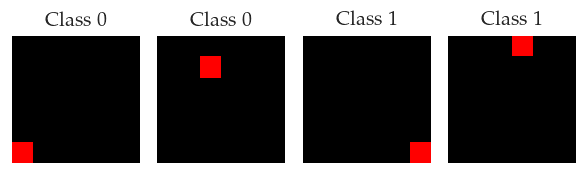

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['seaborn'])
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Palatino"]})
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

fig, axs = plt.subplots(1, 4, figsize=(1 + 2 * 2, 2), dpi=120)
j = 0
for c in range(2):
    for i in range(2):
        inds = train_labels == c
        axs[j].imshow(train_images[inds][i].permute((1, 2, 0)))
        axs[j].set_title(f"Class {train_labels[inds][i]}")
        axs[j].axis('off')
        j += 1

plt.tight_layout()
pass

## Model

In [4]:
%autoreload
from toy_models import TriViTalAbsolutePosition

/home/robert-jan/surfdrive/experiments/vit-position-info/toy-experiments/../models/irpe.py:14: UserWarning: [WARNING] The module `rpe_ops` is not built. For better training performance, please build `rpe_ops`.
  warnings.warn(RED_STR.format("[WARNING] The module `rpe_ops` is not built. \


# Handcrafted solution

In [12]:
%autoreload

import training
from utils import toy_analysis

# Handcrafted weights
pos_embs = torch.tensor([-1, -1, -1, 1, 1, 1] * 6).view(1, 1, 6, 6).float()
handcrafted_weights = {
    'patch_layer.weight': torch.tensor([[[[1.]], [[0.]], [[0.]]]]),
    'patch_layer.bias': torch.tensor([0.]),
    'pos_embedding': pos_embs,
    'block1.attn.query.weight': torch.tensor([[1., 0.], [0., 0.]]),
    'block1.attn.query.bias': torch.tensor([0., 0.]),
    'block1.attn.key.weight': torch.tensor([[1., 0.], [0., 0.]]),
    'block1.attn.key.bias': torch.tensor([0., 0.]),
    'block1.attn.value.weight': torch.diag(torch.tensor([1., 1.])),
    'block1.attn.value.bias': torch.tensor([0.,0.]),
    'block1.attn.out.weight': torch.diag(torch.tensor([1., 1.])),
    'block1.attn.out.bias': torch.tensor([0., 0.]),
    'block1.ffn.fc1.weight': torch.diag(torch.tensor([1., 1.])),
    'block1.ffn.fc1.bias': torch.tensor([0., 0.]),
    'block1.ffn.fc2.weight': torch.tensor([[0., 1.],[0., 0.]]),
    'block1.ffn.fc2.bias': torch.tensor([0., 0.]),
    'block1.attn.rel_pos.emb_w.rel_pos_emb': torch.zeros((11, 2), dtype=torch.float32),
    'block1.attn.rel_pos.emb_h.rel_pos_emb': torch.zeros((11, 2), dtype=torch.float32),
    'fc.weight': torch.tensor([[-1., 0.], [1., 0.]]),
    'fc.bias': torch.tensor([0., 0.]),
}
model = TriViTal(d=2, n_classes=n_classes, handcrafted_weights=handcrafted_weights, n_heads=1, pos_emb='absolute', pool='max', norm=False, residual=False, pos_add='concat')
training.test_toy(model, test_images, test_labels)

# Analysis
seed = 0
n_samples = None
targets = ['pred_class']
shape = 'scalar'
# targets = ['attn_out_sliced']
# shape = 'head'
patch_size = 1
exclude_bias = True

toy_analysis(targets, shape, patch_size, seed, n_samples, model, test_images, test_labels, exclude_bias=exclude_bias)


No parameters to train!
Accuracy: 1.0


{'appearance': tensor(0.0639),
 'position': tensor(0.9361),
 'relative_position': tensor(0.)}

# Training solution

In [5]:
%autoreload
from experiments import run as run_absolute_position

### APE - full WD results

In [4]:
import pandas as pd
from io import StringIO

results = """
index,mean_acc,mean_appearance,std_appearance,mean_position,std_position,mean_relative_position,std_relative_position,lr,pos_emb_factor,weight_decay,pos_emb_init,position_mix,ape,rpe
0,1.0,0.18465469777584076,0.14725589752197266,0.815345287322998,0.14725589752197266,0,0,0.004,0.1,0.0,trunc_normal,6/0,True,False
1,1.0,0.1850435882806778,0.14869986474514008,0.8149564862251282,0.14869987964630127,0,0,0.004,0.1,1e-08,trunc_normal,6/0,True,False
2,1.0,0.18353351950645447,0.14802640676498413,0.8164665102958679,0.14802639186382294,0,0,0.004,0.1,1e-07,trunc_normal,6/0,True,False
3,1.0,0.19638410210609436,0.14956063032150269,0.803615927696228,0.14956063032150269,0,0,0.004,0.1,1e-06,trunc_normal,6/0,True,False
4,1.0,0.1827016919851303,0.1551869809627533,0.8172982931137085,0.1551869660615921,0,0,0.004,0.1,1e-05,trunc_normal,6/0,True,False
5,1.0,0.2882639169692993,0.22047016024589539,0.7117360830307007,0.220470130443573,0,0,0.004,0.1,0.0001,trunc_normal,6/0,True,False
6,0.949999988079071,0.368843138217926,0.3373698890209198,0.6311568021774292,0.3373698890209198,0,0,0.004,0.1,0.001,trunc_normal,6/0,True,False
7,0.5249999761581421,0.18722280859947205,0.3315744400024414,0.8127771615982056,0.3315744996070862,0,0,0.004,0.1,0.01,trunc_normal,6/0,True,False
8,0.5,0.31655609607696533,0.43386024236679077,0.6834439039230347,0.4338602125644684,0,0,0.004,0.1,0.1,trunc_normal,6/0,True,False
9,1.0,0.18250194191932678,0.10321247577667236,0.8174980282783508,0.10321246087551117,0,0,0.04,0.1,0.0,trunc_normal,6/0,True,False
10,1.0,0.2013690024614334,0.11589447408914566,0.7986308932304382,0.11589445173740387,0,0,0.04,0.1,1e-08,trunc_normal,6/0,True,False
11,1.0,0.21074631810188293,0.1250082105398178,0.7892537117004395,0.125008225440979,0,0,0.04,0.1,1e-07,trunc_normal,6/0,True,False
12,1.0,0.21894951164722443,0.16061368584632874,0.7810505032539368,0.16061367094516754,0,0,0.04,0.1,1e-06,trunc_normal,6/0,True,False
13,1.0,0.35311049222946167,0.26448431611061096,0.6468895673751831,0.26448434591293335,0,0,0.04,0.1,1e-05,trunc_normal,6/0,True,False
14,1.0,0.5654149651527405,0.3553342819213867,0.43458500504493713,0.3553342819213867,0,0,0.04,0.1,0.0001,trunc_normal,6/0,True,False
15,0.6499999761581421,0.1462709903717041,0.21109193563461304,0.8537290692329407,0.21109193563461304,0,0,0.04,0.1,0.001,trunc_normal,6/0,True,False
16,0.5,0.1107674092054367,0.29698002338409424,0.3392326235771179,0.46244239807128906,0,0,0.04,0.1,0.01,trunc_normal,6/0,True,False
17,0.5,4.5345511784564943e-17,9.312334485161961e-17,0.6499999761581421,0.4769695997238159,0,0,0.04,0.1,0.1,trunc_normal,6/0,True,False
0,1.0,0.22857901453971863,0.19031578302383423,0.0,0.0,0.7714208960533142,0.19031578302383423,0.004,0.1,0.0,trunc_normal,6/0,False,True
1,1.0,0.2282613217830658,0.18962427973747253,0.0,0.0,0.7717387676239014,0.18962429463863373,0.004,0.1,1e-08,trunc_normal,6/0,False,True
2,1.0,0.22394819557666779,0.18156345188617706,0.0,0.0,0.7760517597198486,0.18156346678733826,0.004,0.1,1e-07,trunc_normal,6/0,False,True
3,1.0,0.22997446358203888,0.19045913219451904,0.0,0.0,0.7700255513191223,0.19045913219451904,0.004,0.1,1e-06,trunc_normal,6/0,False,True
4,1.0,0.21806709468364716,0.16896922886371613,0.0,0.0,0.7819329500198364,0.16896924376487732,0.004,0.1,1e-05,trunc_normal,6/0,False,True
5,1.0,0.20589745044708252,0.17495253682136536,0.0,0.0,0.7941025495529175,0.17495252192020416,0.004,0.1,0.0001,trunc_normal,6/0,False,True
6,0.800000011920929,0.4860379695892334,0.43136459589004517,0.0,0.0,0.5139620304107666,0.43136459589004517,0.004,0.1,0.001,trunc_normal,6/0,False,True
7,0.5,1.0,0.0,0.0,0.0,1.958909274313379e-17,8.538655252884374e-17,0.004,0.1,0.01,trunc_normal,6/0,False,True
8,0.5,1.0,0.0,0.0,0.0,0.0,0.0,0.004,0.1,0.1,trunc_normal,6/0,False,True
9,1.0,0.22188016772270203,0.20194901525974274,0.0,0.0,0.7781198620796204,0.20194903016090393,0.04,0.1,0.0,trunc_normal,6/0,False,True
10,1.0,0.2036854773759842,0.1498693972826004,0.0,0.0,0.796314537525177,0.1498693972826004,0.04,0.1,1e-08,trunc_normal,6/0,False,True
11,1.0,0.18122181296348572,0.14463576674461365,0.0,0.0,0.8187781572341919,0.14463576674461365,0.04,0.1,1e-07,trunc_normal,6/0,False,True
12,1.0,0.21323159337043762,0.18647588789463043,0.0,0.0,0.7867684364318848,0.18647587299346924,0.04,0.1,1e-06,trunc_normal,6/0,False,True
13,1.0,0.16028571128845215,0.10225548595190048,0.0,0.0,0.8397142291069031,0.10225549340248108,0.04,0.1,1e-05,trunc_normal,6/0,False,True
14,0.925000011920929,0.2557540535926819,0.31739386916160583,0.0,0.0,0.7442458868026733,0.31739386916160583,0.04,0.1,0.0001,trunc_normal,6/0,False,True
15,0.5416666269302368,0.9464847445487976,0.1829303503036499,0.0,0.0,0.05351526290178299,0.1829303652048111,0.04,0.1,0.001,trunc_normal,6/0,False,True
16,0.5,0.4000000059604645,0.4898979961872101,0.0,0.0,0.0,0.0,0.04,0.1,0.01,trunc_normal,6/0,False,True
17,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.1,0.1,trunc_normal,6/0,False,True
0,1.0,0.140218123793602,0.07060942053794861,0.571333646774292,0.1385464072227478,0.2884482145309448,0.1315944641828537,0.004,0.1,0.0,trunc_normal,6/0,True,True
1,1.0,0.14060473442077637,0.0716010257601738,0.5713137984275818,0.13848325610160828,0.28808146715164185,0.13152308762073517,0.004,0.1,1e-08,trunc_normal,6/0,True,True
2,1.0,0.14268968999385834,0.07713447511196136,0.5717847347259521,0.13857313990592957,0.2855256497859955,0.13236556947231293,0.004,0.1,1e-07,trunc_normal,6/0,True,True
3,1.0,0.14366832375526428,0.07186859101057053,0.5753397941589355,0.13402342796325684,0.28099194169044495,0.12249051779508591,0.004,0.1,1e-06,trunc_normal,6/0,True,True
4,1.0,0.1454957276582718,0.08200502395629883,0.5644043684005737,0.12898500263690948,0.2900998592376709,0.13782277703285217,0.004,0.1,1e-05,trunc_normal,6/0,True,True
5,1.0,0.23231205344200134,0.13163374364376068,0.5120539665222168,0.11227501928806305,0.2556338608264923,0.09955859929323196,0.004,0.1,0.0001,trunc_normal,6/0,True,True
6,0.9750000238418579,0.3948916792869568,0.272541880607605,0.4802495539188385,0.23106332123279572,0.12485873699188232,0.11089769750833511,0.004,0.1,0.001,trunc_normal,6/0,True,True
7,0.6499999761581421,0.20860564708709717,0.2726481556892395,0.779525876045227,0.29064661264419556,0.011868519708514214,0.022359054535627365,0.004,0.1,0.01,trunc_normal,6/0,True,True
8,0.5,0.17415961623191833,0.35118067264556885,0.8258403539657593,0.35118067264556885,0.0,0.0,0.004,0.1,0.1,trunc_normal,6/0,True,True
9,1.0,0.1953405737876892,0.11697053164243698,0.5776494741439819,0.1253850907087326,0.22700992226600647,0.13965941965579987,0.04,0.1,0.0,trunc_normal,6/0,True,True
10,1.0,0.19515569508075714,0.11590723693370819,0.590796947479248,0.13572008907794952,0.2140474021434784,0.1375274509191513,0.04,0.1,1e-08,trunc_normal,6/0,True,True
11,1.0,0.19437041878700256,0.11833342909812927,0.5905664563179016,0.13490867614746094,0.2150631695985794,0.12711432576179504,0.04,0.1,1e-07,trunc_normal,6/0,True,True
12,1.0,0.19179357588291168,0.10104189813137054,0.5716844797134399,0.10799378156661987,0.23652192950248718,0.12229270488023758,0.04,0.1,1e-06,trunc_normal,6/0,True,True
13,1.0,0.359531044960022,0.1514318436384201,0.40476760268211365,0.136174276471138,0.23570139706134796,0.15442603826522827,0.04,0.1,1e-05,trunc_normal,6/0,True,True
14,1.0,0.6594197750091553,0.250505268573761,0.24388006329536438,0.18295882642269135,0.09670023620128632,0.1274891495704651,0.04,0.1,0.0001,trunc_normal,6/0,True,True
15,0.831944465637207,0.32355231046676636,0.3101407289505005,0.5963138341903687,0.33031582832336426,0.08013375103473663,0.10747510194778442,0.04,0.1,0.001,trunc_normal,6/0,True,True
16,0.5,0.07149622589349747,0.2144106775522232,0.6785037517547607,0.4446614980697632,0.0,0.0,0.04,0.1,0.01,trunc_normal,6/0,True,True
17,0.5,5.657587164595648e-16,1.9721842923001035e-15,0.8500000238418579,0.3570714294910431,0.0,0.0,0.04,0.1,0.1,trunc_normal,6/0,True,True
"""

df = pd.read_csv(StringIO(results), sep=",")

# Remove rows where mean_acc is below 1.0
df = df[df['mean_acc'] == 1.0]

df['mean_total_position'] = df['mean_position'] + df['mean_relative_position']
df['std_total_position'] = df['std_position'] + df['std_relative_position']
df = df.drop(columns=['mean_position', 'std_position', 'mean_relative_position', 'std_relative_position'])

# Remove column
df = df.drop(columns=['index', 'position_mix', 'pos_emb_init', 'pos_emb_factor', 'mean_acc'])
# df = df.drop(columns=['index', 'position_mix', 'pos_emb_init', 'pos_emb_factor'])

# Set Pandas to display all rows
pd.set_option('display.max_rows', None)

# Make column with string representations of ape and rpe concatenated
df['pe'] = df['ape'].astype(str) + '/' + df['rpe'].astype(str)

df

,mean_appearance,std_appearance,lr,weight_decay,ape,rpe,mean_total_position,std_total_position,pe
0,0.184655,0.147256,0.004,0.000000e+00,True,False,0.815345,0.147256,True/False
1,0.185044,0.148700,0.004,1.000000e-08,True,False,0.814956,0.148700,True/False
2,0.183534,0.148026,0.004,1.000000e-07,True,False,0.816467,0.148026,True/False
3,0.196384,0.149561,0.004,1.000000e-06,True,False,0.803616,0.149561,True/False
4,0.182702,0.155187,0.004,1.000000e-05,True,False,0.817298,0.155187,True/False
5,0.288264,0.220470,0.004,1.000000e-04,True,False,0.711736,0.220470,True/False
9,0.182502,0.103212,0.040,0.000000e+00,True,False,0.817498,0.103212,True/False
10,0.201369,0.115894,0.040,1.000000e-08,True,False,0.798631,0.115894,True/False
11,0.210746,0.125008,0.040,1.000000e-07,True,False,0.789254,0.125008,True/False
12,0.218950,0.160614,0.040,1.000000e-06,True,False,0.781051,0.160614,True/False


Results: use LR 4e-3 for the most consistent results: ~80% P for both APE & RPE

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:title={'center':'Toy \\#2: Absolute position - AP+RP sensitivity'}, xlabel='Weight decay', ylabel='AP+RP sensitivity (mean over 20 seeds)'>

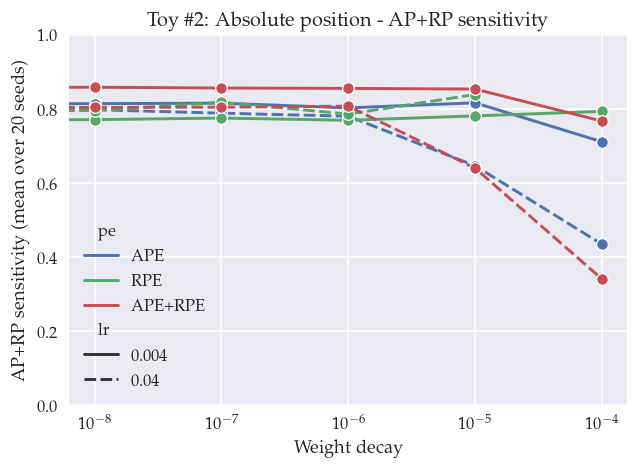

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['seaborn'])
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Palatino"]})
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

plot_df = df.copy()
# plot_df = plot_df[plot_df['lr'] == 4e-3]
plot_df.loc[(df.pe == 'True/False'), 'pe'] = 'APE'
plot_df.loc[(df.pe == 'False/True'), 'pe'] = 'RPE'
plot_df.loc[(df.pe == 'True/True'), 'pe'] = 'APE+RPE'

# Plot lines: x = weight_decay, y = mean_total_position, for each ape + rpe combination, including std_total_position
fig, axs = plt.subplots(1, 1, figsize=(6, 4), dpi=120)
axs.set_xscale('log')
axs.set_ylim([0, 1])
axs.set_xlabel('Weight decay')
axs.set_ylabel('AP+RP sensitivity (mean over 20 seeds)')
axs.set_title('Toy \#2: Absolute position - AP+RP sensitivity')
sns.lineplot(data=plot_df, x='weight_decay', y='mean_total_position', hue='pe', style='lr', ax=axs, marker='o')

<ErrorbarContainer object of 3 artists>

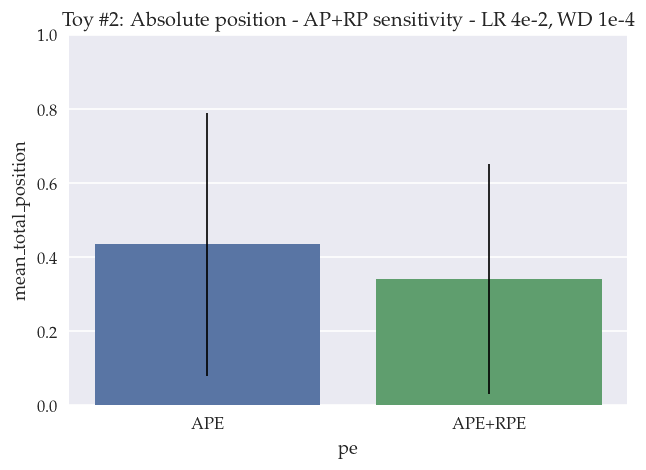

In [6]:
plot_df = df.copy()
plot_df.loc[(df.pe == 'True/False'), 'pe'] = 'APE'
plot_df.loc[(df.pe == 'False/True'), 'pe'] = 'RPE'
plot_df.loc[(df.pe == 'True/True'), 'pe'] = 'APE+RPE'
plot_df = plot_df[plot_df['lr'] == 4e-2]
plot_df = plot_df[plot_df['weight_decay'] == 1e-4]

# Make barplot: x = pe, y = mean_total_position, yerr = std_total_position
fig, axs = plt.subplots(1, 1, figsize=(6, 4), dpi=120)
axs.set_ylim([0, 1])
axs.set_xlabel('Position encoding')
axs.set_ylabel('AP+RP sensitivity (mean over 20 seeds)')
axs.set_title('Toy \#2: Absolute position - AP+RP sensitivity - LR 4e-2, WD 1e-4')
ax = sns.barplot(data=plot_df, x='pe', y='mean_total_position', ax=axs)
x_coords = [p.get_x() + 0.5 * p.get_width() for p in ax.patches]
y_coords = [p.get_height() for p in ax.patches]
ax.errorbar(x=x_coords, y=y_coords, yerr=plot_df["std_total_position"], fmt="none", c="k", elinewidth=1)

### Debug APE - weight decay

In [6]:
%autoreload

# Train / hybrid
# seeds = range(10)
seeds = [0]
n_epochs = 4000
report_every_n = 2000
lr = 4e-3
# d = 1
# n_heads = 1
n_classes = 2
pos_emb = 'absolute'
use_rel_pos = False
weight_decays = [1e-8, 1e-6, 1e-4, 1e-3]

# Test these settings
lr = 4e-3
d = 4
n_heads = 2
attribution_method = 'input_gradient_withnegative'

for weight_decay in weight_decays:
    print(f"\n\nWeight decay: {weight_decay}")
    run_absolute_position('absolute_position', seeds, n_epochs, lr, d, n_heads, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=report_every_n, attribution_method=attribution_method, weight_decay=weight_decay)



Weight decay: 1e-08
Epoch 0: 0.7141404151916504
Epoch 2000: 3.841179022856522e-06
Epoch 3999: 7.384349487438158e-07
Accuracy: 1.0

Without bias:
appearance (all): 13.78 +- 0.00 (13.78)
appearance (c0) : 3.79 +- 0.00 (3.79)
appearance (c1) : 23.77 +- 0.00 (23.77)
position (all): 86.22 +- 0.00 (86.22)
position (c0) : 96.21 +- 0.00 (96.21)
position (c1) : 76.23 +- 0.00 (76.23)

With bias:
bias (all): 54.88 +- 0.00 (54.88)
bias (c0) : 46.83 +- 0.00 (46.83)
bias (c1) : 62.93 +- 0.00 (62.93)
appearance (all): 5.68 +- 0.00 (5.68)
appearance (c0) : 2.04 +- 0.00 (2.04)
appearance (c1) : 9.32 +- 0.00 (9.32)
position (all): 39.44 +- 0.00 (39.44)
position (c0) : 51.13 +- 0.00 (51.13)
position (c1) : 27.75 +- 0.00 (27.75)



Weight decay: 1e-06
Epoch 0: 0.7141404151916504


/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 2000: 4.019992502435343e-06
Epoch 3999: 8.907578035177721e-07
Accuracy: 1.0

Without bias:
appearance (all): 14.10 +- 0.00 (14.10)
appearance (c0) : 4.01 +- 0.00 (4.01)
appearance (c1) : 24.19 +- 0.00 (24.19)
position (all): 85.90 +- 0.00 (85.90)
position (c0) : 95.99 +- 0.00 (95.99)
position (c1) : 75.81 +- 0.00 (75.81)

With bias:
bias (all): 54.32 +- 0.00 (54.32)
bias (c0) : 47.01 +- 0.00 (47.01)
bias (c1) : 61.63 +- 0.00 (61.63)
appearance (all): 5.85 +- 0.00 (5.85)
appearance (c0) : 2.14 +- 0.00 (2.14)
appearance (c1) : 9.56 +- 0.00 (9.56)
position (all): 39.83 +- 0.00 (39.83)
position (c0) : 50.85 +- 0.00 (50.85)
position (c1) : 28.82 +- 0.00 (28.82)



Weight decay: 0.0001
Epoch 0: 0.7141404151916504
Epoch 2000: 3.441751323407516e-05


KeyboardInterrupt: 

### No PE - with negative

In [12]:
# Train / hybrid
seeds = range(10)
n_epochs = 4000
report_every_n = 2000
lr = 4e-3
# d = 1
# n_heads = 1
n_classes = 2
pos_emb = 'none'
use_rel_pos = False

# Test these settings
d = 4
n_heads = 2

run_absolute_position(seeds, n_epochs, lr, d, n_heads, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=report_every_n, attribution_method='input_gradient_withnegative')

Epoch 0: 0.8161522746086121
Epoch 2000: 0.6931472420692444
Epoch 3999: 0.6931473016738892
Accuracy: 0.5
Epoch 0: 0.7026712894439697
Epoch 2000: 0.6931471228599548
Epoch 3999: 0.6931473016738892
Accuracy: 0.5
Epoch 0: 0.8941465020179749
Epoch 2000: 0.6931473016738892
Epoch 3999: 0.6931471824645996
Accuracy: 0.5
Epoch 0: 0.6956092715263367
Epoch 2000: 0.6931471824645996
Epoch 3999: 0.6931473016738892
Accuracy: 0.5
Epoch 0: 0.7431373000144958
Epoch 2000: 0.6931473016738892
Epoch 3999: 0.6931472420692444
Accuracy: 0.5
Epoch 0: 0.7022227048873901
Epoch 2000: 0.6931471824645996
Epoch 3999: 0.6931471228599548
Accuracy: 0.5
Epoch 0: 0.7020537853240967
Epoch 2000: 0.6931473016738892
Epoch 3999: 0.6931471824645996
Accuracy: 0.5
Epoch 0: 0.7772420644760132
Epoch 2000: 0.6931471824645996
Epoch 3999: 0.6931471824645996
Accuracy: 0.5
Epoch 0: 0.960723340511322
Epoch 2000: 0.6931473016738892
Epoch 3999: 0.6931473016738892
Accuracy: 0.5
Epoch 0: 0.8857744336128235
Epoch 2000: 0.6931471824645996
Epoch 

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### No PE

In [8]:
# Train / hybrid
seeds = range(10)
n_epochs = 4000
report_every_n = 2000
lr = 4e-3
# d = 1
# n_heads = 1
n_classes = 2
pos_emb = 'none'
use_rel_pos = False

# Test these settings
d = 4
n_heads = 2

run_absolute_position(seeds, n_epochs, lr, d, n_heads, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=report_every_n)

Epoch 0: 0.8161522746086121


Epoch 2000: 0.6931473016738892
Accuracy: 0.5
Epoch 0: 0.7026712894439697
Epoch 2000: 0.6931471824645996
Accuracy: 0.5
Epoch 0: 0.8941463828086853
Epoch 2000: 0.6931471228599548
Accuracy: 0.5
Epoch 0: 0.6956092715263367
Epoch 2000: 0.6931471824645996
Accuracy: 0.5
Epoch 0: 0.7431373000144958
Epoch 2000: 0.6931473016738892
Accuracy: 0.5
Epoch 0: 0.7022227048873901
Epoch 2000: 0.6931471824645996
Accuracy: 0.5
Epoch 0: 0.7020537853240967
Epoch 2000: 0.6931472420692444
Accuracy: 0.5
Epoch 0: 0.7772420644760132
Epoch 2000: 0.6931471228599548
Accuracy: 0.5
Epoch 0: 0.9607234597206116
Epoch 2000: 0.6931471824645996
Accuracy: 0.5
Epoch 0: 0.8857744932174683
Epoch 2000: 0.6931471824645996
Accuracy: 0.5

Without bias:
appearance (all): 80.00 +- 40.00 (0.00, 100.00, 100.00, 100.00, 100.00, 100.00, 0.00, 100.00, 100.00, 100.00)
appearance (c0) : 80.00 +- 40.00 (0.00, 100.00, 100.00, 100.00, 100.00, 100.00, 0.00, 100.00, 100.00, 100.00)
appearance (c1) : 80.00 +- 40.00 (0.00, 100.00, 100.00, 100.00,

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### APE - fix zero grad

In [9]:
%autoreload

# Train / hybrid
seeds = range(10)
n_epochs = 4000
report_every_n = 2000
lr = 4e-3
# d = 1
# n_heads = 1
n_classes = 2
pos_emb = 'absolute'
use_rel_pos = False


# Test these settings
lr = 4e-3
d = 4
n_heads = 2
attribution_method = 'input_gradient_withnegative'

run_absolute_position(seeds, n_epochs, lr, d, n_heads, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=report_every_n, attribution_method=attribution_method)

Epoch 0: 0.7141404747962952
Epoch 2000: 3.837867097900016e-06
Epoch 3999: 7.384350055872346e-07
Accuracy: 1.0


/home/robert-jan/surfdrive/experiments/vit-position-info/toy-experiments/../analysis/learned_relative_position.py:170: RuntimeWarning: Mean of empty slice.
  return sf.mean()
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 0: 0.6971418857574463
Epoch 2000: 1.9287754184915684e-05
Epoch 3999: 4.311355951358564e-06
Accuracy: 1.0
Epoch 0: 0.7413167953491211
Epoch 2000: 2.50670314017043e-06
Epoch 3999: 4.1723248500602494e-07
Accuracy: 1.0
Epoch 0: 0.7181055545806885
Epoch 2000: 4.397486918605864e-06
Epoch 3999: 7.781713975418825e-07
Accuracy: 1.0
Epoch 0: 0.6970670819282532
Epoch 2000: 6.496704827441135e-06
Epoch 3999: 3.079568671182642e-07
Accuracy: 1.0
Epoch 0: 0.79866623878479
Epoch 2000: 4.486894340516301e-06
Epoch 3999: 8.44398812205327e-07
Accuracy: 1.0
Epoch 0: 0.7417094111442566
Epoch 2000: 3.5232887967140414e-06
Epoch 3999: 6.556508651556214e-07
Accuracy: 1.0
Epoch 0: 0.7666622400283813
Epoch 2000: 0.0001991216413443908
Epoch 3999: 3.630545688793063e-05
Accuracy: 1.0
Epoch 0: 0.6997612714767456
Epoch 2000: 4.228603302181e-06
Epoch 3999: 7.781712270116259e-07
Accuracy: 1.0
Epoch 0: 0.7541452050209045
Epoch 2000: 6.937293164810399e-06
Epoch 3999: 1.225205892296799e-06
Accuracy: 1.0

Without bias:

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### APE - with negative

In [11]:
# Train / hybrid
seeds = range(10)
n_epochs = 4000
report_every_n = 2000
lr = 4e-3
# d = 1
# n_heads = 1
n_classes = 2
pos_emb = 'absolute'
use_rel_pos = False


# Test these settings
lr = 4e-3
d = 4
n_heads = 2
attribution_method = 'input_gradient_withnegative'

run_absolute_position(seeds, n_epochs, lr, d, n_heads, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=report_every_n, attribution_method=attribution_method)

Epoch 0: 0.7141404747962952
Epoch 2000: 3.834556082438212e-06
Epoch 3999: 7.384350624306535e-07
Accuracy: 1.0


/home/robert-jan/surfdrive/experiments/vit-position-info/toy-experiments/../analysis/learned_relative_position.py:170: RuntimeWarning: Mean of empty slice.
  return sf.mean()
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 0: 0.6971418857574463
Epoch 2000: 1.450621221010806e-05
Epoch 3999: 2.1225723685347475e-06
Accuracy: 1.0
Epoch 0: 0.7413167357444763
Epoch 2000: 2.50670314017043e-06
Epoch 3999: 4.1723248500602494e-07
Accuracy: 1.0
Epoch 0: 0.7181056141853333
Epoch 2000: 4.397486918605864e-06
Epoch 3999: 7.781714543853013e-07
Accuracy: 1.0
Epoch 0: 0.6970670223236084
Epoch 2000: 1.4927246411389206e-05
Epoch 3999: 1.6689264157321304e-06
Accuracy: 1.0
Epoch 0: 0.79866623878479
Epoch 2000: 4.486894795263652e-06
Epoch 3999: 8.44398812205327e-07
Accuracy: 1.0
Epoch 0: 0.7417094111442566
Epoch 2000: 3.5232887967140414e-06
Epoch 3999: 6.556508651556214e-07
Accuracy: 1.0
Epoch 0: 0.7666622400283813
Epoch 2000: 0.0002047999296337366
Epoch 3999: 3.713645855896175e-05
Accuracy: 1.0
Epoch 0: 0.6997613310813904
Epoch 2000: 4.228602847433649e-06
Epoch 3999: 7.781712270116259e-07
Accuracy: 1.0
Epoch 0: 0.7541452050209045
Epoch 2000: 6.9372940743051e-06
Epoch 3999: 1.225205892296799e-06
Accuracy: 1.0

Without bi

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### APE

In [9]:
# Train / hybrid
seeds = range(10)
n_epochs = 4000
report_every_n = 2000
lr = 4e-3
# d = 1
# n_heads = 1
n_classes = 2
pos_emb = 'absolute'
use_rel_pos = False

# Test these settings
lr = 4e-3
d = 4
n_heads = 2

run_absolute_position(seeds, n_epochs, lr, d, n_heads, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=report_every_n)

Epoch 0: 0.7141404747962952
Epoch 2000: 3.834555627690861e-06
Epoch 3999: 7.384349487438158e-07
Accuracy: 1.0
Epoch 0: 0.6971418857574463
Epoch 2000: 4.963694209436653e-06
Epoch 3999: 2.046419240286923e-06
Accuracy: 1.0
Epoch 0: 0.7413167357444763
Epoch 2000: 2.50670314017043e-06
Epoch 3999: 4.1723248500602494e-07
Accuracy: 1.0
Epoch 0: 0.7181055545806885
Epoch 2000: 4.397487373353215e-06
Epoch 3999: 7.781713406984636e-07
Accuracy: 1.0
Epoch 0: 0.6970670223236084
Epoch 2000: 2.7351748030923773e-06
Epoch 3999: 1.738465357448149e-06
Accuracy: 1.0
Epoch 0: 0.79866623878479
Epoch 2000: 4.486894795263652e-06
Epoch 3999: 8.44398812205327e-07
Accuracy: 1.0
Epoch 0: 0.7417094707489014
Epoch 2000: 3.5232887967140414e-06
Epoch 3999: 6.556508651556214e-07
Accuracy: 1.0
Epoch 0: 0.7666622996330261
Epoch 2000: 0.00020398230117280036
Epoch 3999: 3.7037130823591724e-05
Accuracy: 1.0
Epoch 0: 0.6997612118721008
Epoch 2000: 4.228603302181e-06
Epoch 3999: 7.78171170168207e-07
Accuracy: 1.0
Epoch 0: 0.75

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


LR 4e-2

Without bias:
appearance (all): 16.58 +- 14.81 (0.34, 2.01, 42.88, 2.96, 9.41, 22.38, 33.47, 1.48, 19.03, 31.89)
appearance (c0) : 2.06 +- 4.07 (0.00, 0.00, 1.61, 0.00, 4.56, 0.00, 0.00, 0.03, 0.86, 13.55)
appearance (c1) : 30.38 +- 27.27 (3.87, 4.02, 53.15, 5.91, 16.13, 87.90, 51.69, 2.87, 34.36, 43.90)
position (all): 83.42 +- 14.81 (99.66, 97.99, 57.12, 97.04, 90.59, 77.62, 66.53, 98.52, 80.97, 68.11)
position (c0) : 97.94 +- 4.07 (100.00, 100.00, 98.39, 100.00, 95.44, 100.00, 100.00, 99.97, 99.14, 86.45)
position (c1) : 69.62 +- 27.27 (96.13, 95.98, 46.85, 94.09, 83.87, 12.10, 48.31, 97.13, 65.64, 56.10)

With bias:
bias (all): 59.87 +- 15.02 (28.80, 59.51, 57.14, 75.81, 56.46, 43.40, 62.70, 62.09, 86.06, 66.70)
bias (c0) : 61.20 +- 21.64 (18.31, 56.33, 86.07, 71.87, 72.06, 69.14, 64.23, 23.12, 70.77, 80.07)
bias (c1) : 59.45 +- 20.61 (79.77, 66.64, 19.03, 78.16, 53.12, 32.29, 54.90, 80.36, 80.87, 49.32)
appearance (all): 8.87 +- 9.89 (0.22, 0.64, 30.61, 0.92, 4.33, 19.77, 13.09, 0.37, 3.45, 15.33)
appearance (c0) : 0.47 +- 0.89 (0.00, 0.00, 0.23, 0.00, 1.32, 0.00, 0.00, 0.02, 0.25, 2.89)
appearance (c1) : 17.40 +- 20.13 (1.00, 1.28, 43.67, 1.83, 7.57, 61.99, 23.51, 0.70, 6.59, 25.82)
position (all): 31.26 +- 16.94 (70.98, 39.85, 12.24, 23.28, 39.21, 36.83, 24.21, 37.54, 10.48, 17.98)
position (c0) : 38.33 +- 22.01 (81.69, 43.67, 13.70, 28.13, 26.62, 30.86, 35.77, 76.86, 28.98, 17.05)
position (c1) : 23.16 +- 10.03 (19.23, 32.08, 37.30, 20.01, 39.31, 5.71, 21.59, 18.94, 12.54, 24.86)

### RPE - fix zero grad

In [10]:
%autoreload

# Train / hybrid
seeds = range(10)
n_epochs = 4000
report_every_n = 2000
lr = 4e-3
# d = 1
# n_heads = 1
n_classes = 2
pos_emb = 'none'
use_rel_pos = True

# Test these settings
lr = 4e-3
d = 4
n_heads = 2

run_absolute_position(seeds, n_epochs, lr, d, n_heads, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=report_every_n, attribution_method='input_gradient_withnegative')

Epoch 0: 0.7099239230155945
Epoch 2000: 2.963666020150413e-06
Epoch 3999: 7.318119514820864e-07
Accuracy: 1.0
Epoch 0: 0.7364419102668762
Epoch 2000: 5.109419362270273e-06
Epoch 3999: 7.947281233100512e-07
Accuracy: 1.0
Epoch 0: 0.7509310245513916
Epoch 2000: 6.781615866202628e-06
Epoch 3999: 1.2020245776511729e-06
Accuracy: 1.0
Epoch 0: 0.6987582445144653
Epoch 2000: 5.238522589934291e-06
Epoch 3999: 4.03986604169404e-07
Accuracy: 1.0
Epoch 0: 0.7915663719177246
Epoch 2000: 4.5001252146903425e-06
Epoch 3999: 7.914165394140582e-07
Accuracy: 1.0
Epoch 0: 0.7256244421005249
Epoch 2000: 1.153328048530966e-05
Epoch 3999: 2.0861550638073822e-06
Accuracy: 1.0
Epoch 0: 0.7060986161231995
Epoch 2000: 6.1789824030711316e-06
Epoch 3999: 1.033146190820844e-06
Accuracy: 1.0
Epoch 0: 0.8814968466758728
Epoch 2000: 1.0606167052173987e-05
Epoch 3999: 1.9040320466956473e-06
Accuracy: 1.0
Epoch 0: 0.712753415107727
Epoch 2000: 3.4636784675967647e-06
Epoch 3999: 6.523392812596285e-07
Accuracy: 1.0
Epoch

### RPE - with negative

In [13]:
# Train / hybrid
seeds = range(10)
n_epochs = 4000
report_every_n = 2000
lr = 4e-3
# d = 1
# n_heads = 1
n_classes = 2
pos_emb = 'none'
use_rel_pos = True

# Test these settings
lr = 4e-3
d = 4
n_heads = 2

run_absolute_position(seeds, n_epochs, lr, d, n_heads, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=report_every_n, attribution_method='input_gradient_withnegative')

Epoch 0: 0.7099239826202393
Epoch 2000: 2.963666020150413e-06
Epoch 3999: 7.318120083255053e-07
Accuracy: 1.0
Epoch 0: 0.7364419102668762
Epoch 2000: 5.109419817017624e-06
Epoch 3999: 7.9472818015347e-07
Accuracy: 1.0
Epoch 0: 0.7509310841560364
Epoch 2000: 6.781616320949979e-06
Epoch 3999: 1.2020245776511729e-06
Accuracy: 1.0
Epoch 0: 0.6987582445144653
Epoch 2000: 5.231900104263332e-06
Epoch 3999: 4.039865757476946e-07
Accuracy: 1.0
Epoch 0: 0.7915663719177246
Epoch 2000: 4.5001256694376934e-06
Epoch 3999: 7.914164825706393e-07
Accuracy: 1.0
Epoch 0: 0.7256244421005249
Epoch 2000: 1.1533279575814959e-05
Epoch 3999: 2.086154836433707e-06
Accuracy: 1.0
Epoch 0: 0.7060985565185547
Epoch 2000: 6.1789828578184824e-06
Epoch 3999: 1.0331463045076816e-06
Accuracy: 1.0
Epoch 0: 0.8814969062805176
Epoch 2000: 1.0606165233184583e-05
Epoch 3999: 1.9007206901733298e-06
Accuracy: 1.0
Epoch 0: 0.7127534747123718
Epoch 2000: 3.4603669973876094e-06
Epoch 3999: 6.523392244162096e-07
Accuracy: 1.0
Epoc

### RPE

In [10]:
# Train / hybrid
seeds = range(10)
n_epochs = 4000
report_every_n = 2000
lr = 4e-3
# d = 1
# n_heads = 1
n_classes = 2
pos_emb = 'none'
use_rel_pos = True

# Test these settings
lr = 4e-3
d = 4
n_heads = 2

run_absolute_position(seeds, n_epochs, lr, d, n_heads, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=report_every_n)

Epoch 0: 0.7099239230155945
Epoch 2000: 2.963666020150413e-06
Epoch 3999: 7.318120083255053e-07
Accuracy: 1.0
Epoch 0: 0.7364418506622314
Epoch 2000: 5.109419817017624e-06
Epoch 3999: 7.947281233100512e-07
Accuracy: 1.0
Epoch 0: 0.7509310245513916
Epoch 2000: 6.781616320949979e-06
Epoch 3999: 1.2020246913380106e-06
Accuracy: 1.0
Epoch 0: 0.6987583041191101
Epoch 2000: 5.231900104263332e-06
Epoch 3999: 4.0398654732598516e-07
Accuracy: 1.0
Epoch 0: 0.7915664315223694
Epoch 2000: 4.5001252146903425e-06
Epoch 3999: 7.914165394140582e-07
Accuracy: 1.0
Epoch 0: 0.7256245017051697
Epoch 2000: 1.1533279575814959e-05
Epoch 3999: 2.0861550638073822e-06
Accuracy: 1.0
Epoch 0: 0.7060984969139099
Epoch 2000: 6.1789824030711316e-06
Epoch 3999: 1.0331463045076816e-06
Accuracy: 1.0
Epoch 0: 0.8814968466758728
Epoch 2000: 1.0606167052173987e-05
Epoch 3999: 1.9007206901733298e-06
Accuracy: 1.0
Epoch 0: 0.7127534747123718
Epoch 2000: 3.463678012849414e-06
Epoch 3999: 6.523391675727908e-07
Accuracy: 1.0
E

LR 4e-2

Without bias:
appearance (all): 16.73 +- 12.31 (33.09, 12.38, 25.68, 17.82, 3.77, 1.13, 8.66, 39.13, 4.46, 21.18)
appearance (c0) : 4.94 +- 8.83 (30.52, 2.32, 4.55, 0.00, 1.13, 0.00, 7.10, 0.00, 3.84, 0.00)
appearance (c1) : 28.51 +- 22.80 (35.65, 22.45, 46.81, 35.64, 6.40, 2.25, 10.23, 78.25, 5.09, 42.36)
relative_position (all): 83.27 +- 12.31 (66.91, 87.62, 74.32, 82.18, 96.23, 98.87, 91.34, 60.87, 95.54, 78.82)
relative_position (c0) : 95.06 +- 8.83 (69.48, 97.68, 95.45, 100.00, 98.87, 100.00, 92.90, 100.00, 96.16, 100.00)
relative_position (c1) : 71.49 +- 22.80 (64.35, 77.55, 53.19, 64.36, 93.60, 97.75, 89.77, 21.75, 94.91, 57.64)

With bias:
bias (all): 54.62 +- 13.14 (58.30, 45.32, 48.07, 49.32, 56.26, 90.30, 52.55, 38.21, 52.30, 55.59)
bias (c0) : 52.41 +- 19.54 (69.80, 32.71, 37.97, 37.74, 45.31, 95.06, 53.73, 53.83, 69.04, 28.89)
bias (c1) : 56.84 +- 18.31 (46.80, 57.93, 58.18, 60.89, 67.21, 85.53, 51.36, 22.60, 35.55, 82.30)
appearance (all): 6.99 +- 8.64 (12.77, 1.88, 9.92, 6.24, 1.09, 0.26, 4.14, 30.12, 1.37, 2.13)
appearance (c0) : 1.29 +- 1.74 (4.79, 1.17, 2.39, 0.00, 0.43, 0.00, 4.09, 0.00, 0.05, 0.00)
appearance (c1) : 12.69 +- 17.21 (20.74, 2.58, 17.44, 12.47, 1.75, 0.51, 4.19, 60.24, 2.69, 4.27)
relative_position (all): 38.39 +- 11.62 (28.94, 52.81, 42.01, 44.45, 42.65, 9.45, 43.31, 31.67, 46.33, 42.27)
relative_position (c0) : 46.30 +- 19.76 (25.41, 66.12, 59.65, 62.26, 54.26, 4.94, 42.17, 46.17, 30.91, 71.11)
relative_position (c1) : 30.47 +- 14.32 (32.46, 39.49, 24.37, 26.63, 31.04, 13.96, 44.44, 17.16, 61.75, 13.44)

### APE+RPE - fix zero grad

In [11]:
# Train / hybrid
seeds = range(10)
n_epochs = 4000
report_every_n = 2000
lr = 4e-3
# d = 1
# n_heads = 1
n_classes = 2
pos_emb = 'absolute'
use_rel_pos = True

# Test these settings
lr = 4e-2
d = 4
n_heads = 2

run_absolute_position(seeds, n_epochs, lr, d, n_heads, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=report_every_n, attribution_method='input_gradient_withnegative')

Epoch 0: 1.0307018756866455
Epoch 2000: 0.0
Epoch 3999: 0.0
Accuracy: 1.0
Epoch 0: 0.7005230784416199
Epoch 2000: 0.0
Epoch 3999: 0.0
Accuracy: 1.0
Epoch 0: 0.8404453992843628
Epoch 2000: 0.0
Epoch 3999: 0.0
Accuracy: 1.0
Epoch 0: 0.6939927935600281
Epoch 2000: 0.0
Epoch 3999: 0.0
Accuracy: 1.0
Epoch 0: 0.6964276432991028
Epoch 2000: 8.6095582219059e-08
Epoch 3999: 3.6425056748612405e-08
Accuracy: 1.0
Epoch 0: 0.7179577350616455
Epoch 2000: 3.1457952900382224e-06
Epoch 3999: 3.4107057444998645e-07
Accuracy: 1.0
Epoch 0: 0.7280700206756592
Epoch 2000: 1.3245475827261544e-08
Epoch 3999: 9.934106870446158e-09
Accuracy: 1.0
Epoch 0: 0.8367326259613037
Epoch 2000: 0.0
Epoch 3999: 0.0
Accuracy: 1.0
Epoch 0: 0.9102523326873779
Epoch 2000: 0.0
Epoch 3999: 0.0
Accuracy: 1.0
Epoch 0: 1.057090401649475
Epoch 2000: 0.0
Epoch 3999: 0.0
Accuracy: 1.0

Without bias:
appearance (all): 12.39 +- 9.82 (14.36, 7.75, 5.90, 23.86, 3.42, 0.41, 10.04, 31.09, 23.12, 4.00)
appearance (c0) : 2.76 +- 2.24 (4.59, 

### APE+RPE with negative

In [14]:
# Train / hybrid
seeds = range(10)
n_epochs = 4000
report_every_n = 2000
lr = 4e-3
# d = 1
# n_heads = 1
n_classes = 2
pos_emb = 'absolute'
use_rel_pos = True

# Test these settings
lr = 4e-2
d = 4
n_heads = 2

run_absolute_position(seeds, n_epochs, lr, d, n_heads, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=report_every_n, attribution_method='input_gradient_withnegative')

Epoch 0: 1.0307018756866455
Epoch 2000: 0.0
Epoch 3999: 0.0
Accuracy: 1.0


/home/robert-jan/surfdrive/experiments/vit-position-info/toy-experiments/../analysis/learned_relative_position.py:170: RuntimeWarning: Mean of empty slice.
  return sf.mean()


Epoch 0: 0.7005230188369751
Epoch 2000: 0.0
Epoch 3999: 0.0
Accuracy: 1.0
Epoch 0: 0.8404455780982971
Epoch 2000: 0.0
Epoch 3999: 0.0
Accuracy: 1.0
Epoch 0: 0.6939928531646729
Epoch 2000: 0.0
Epoch 3999: 0.0
Accuracy: 1.0
Epoch 0: 0.6964276432991028
Epoch 2000: 8.6095582219059e-08
Epoch 3999: 3.6425056748612405e-08
Accuracy: 1.0
Epoch 0: 0.7179577350616455
Epoch 2000: 2.904064785980154e-06
Epoch 3999: 6.126031166786561e-07
Accuracy: 1.0
Epoch 0: 0.7280700206756592
Epoch 2000: 1.3245475827261544e-08
Epoch 3999: 9.934106870446158e-09
Accuracy: 1.0
Epoch 0: 0.8367325067520142
Epoch 2000: 0.0
Epoch 3999: 0.0
Accuracy: 1.0
Epoch 0: 0.9102521538734436
Epoch 2000: 0.0
Epoch 3999: 0.0
Accuracy: 1.0
Epoch 0: 1.0570902824401855
Epoch 2000: 0.0
Epoch 3999: 0.0
Accuracy: 1.0

Without bias:
appearance (all): 14.60 +- 9.81 (14.31, 5.60, 10.97, 31.81, 3.06, 12.10, 14.01, 26.70, 25.68, 1.80)
appearance (c0) : 3.91 +- 3.24 (10.64, 7.43, 4.61, 2.20, 0.11, 2.49, 3.17, 6.65, 1.63, 0.15)
appearance (c1) : 

### APE+RPE

In [11]:
# Train / hybrid
seeds = range(10)
n_epochs = 4000
report_every_n = 2000
lr = 4e-3
# d = 1
# n_heads = 1
n_classes = 2
pos_emb = 'absolute'
use_rel_pos = True

# Test these settings
lr = 4e-2
d = 4
n_heads = 2

run_absolute_position(seeds, n_epochs, lr, d, n_heads, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=report_every_n)

Epoch 0: 1.030701756477356


Epoch 2000: 0.0
Accuracy: 1.0
Epoch 0: 0.7005230188369751
Epoch 2000: 0.0
Accuracy: 1.0
Epoch 0: 0.8404455780982971
Epoch 2000: 0.0
Accuracy: 1.0
Epoch 0: 0.6939927935600281
Epoch 2000: 0.0
Accuracy: 1.0
Epoch 0: 0.696427583694458
Epoch 2000: 5.2981899756332496e-08
Accuracy: 1.0
Epoch 0: 0.7179577350616455
Epoch 2000: 2.7649884941638447e-06
Accuracy: 1.0
Epoch 0: 0.728070080280304
Epoch 2000: 1.3245475827261544e-08
Accuracy: 1.0
Epoch 0: 0.8367326259613037
Epoch 2000: 0.0
Accuracy: 1.0
Epoch 0: 0.9102522730827332
Epoch 2000: 0.0
Accuracy: 1.0
Epoch 0: 1.0570905208587646
Epoch 2000: 0.0
Accuracy: 1.0

Without bias:
appearance (all): 22.35 +- 15.47 (16.04, 8.02, 11.52, 38.16, 7.58, 13.54, 37.47, 43.37, 44.02, 3.73)
appearance (c0) : 1.55 +- 2.57 (0.01, 2.64, 0.00, 0.24, 0.02, 1.46, 8.76, 0.08, 2.06, 0.22)
appearance (c1) : 42.99 +- 28.97 (48.86, 14.40, 23.04, 75.19, 15.11, 11.17, 51.70, 86.65, 84.89, 18.93)
position (all): 48.82 +- 23.18 (67.09, 70.88, 43.57, 20.81, 24.09, 77.12, 45.64, 

Epoch 0: 1.0307018756866455
Epoch 50: 0.692537784576416
Epoch 100: 5.496845574270992e-07
Epoch 150: 2.3510622781941493e-07
Epoch 200: 2.9802306400483758e-08
Epoch 250: 1.9868208411821797e-08
Epoch 300: 9.934105982267738e-09
Epoch 350: 3.311368956815386e-09
Epoch 400: 3.311368956815386e-09
Epoch 450: 0.0
Epoch 500: 0.0
Epoch 550: 0.0
Epoch 600: 0.0
Epoch 650: 0.0
Epoch 700: 0.0
Epoch 750: 0.0
Epoch 800: 0.0
Epoch 850: 0.0
Epoch 900: 0.0
Epoch 950: 0.0
Accuracy: 1.0
Sources: image, pos_emb, relpos, bias
Available sources: image, pos_emb, relpos, bias
100%|██████████| 36/36 [00:01<00:00, 22.93it/s]
Epoch 0: 0.7005230188369751
Epoch 50: 6.041734741302207e-05
Epoch 100: 5.29818819927641e-08
Epoch 150: 6.622737913630772e-09
Epoch 200: 0.0
Epoch 250: 0.0
Epoch 300: 0.0
Epoch 350: 0.0
Epoch 400: 0.0
Epoch 450: 0.0
Epoch 500: 0.0
Epoch 550: 0.0
Epoch 600: 0.0
Epoch 650: 0.0
Epoch 700: 0.0
Epoch 750: 0.0
Epoch 800: 0.0
Epoch 850: 0.0
Epoch 900: 0.0
Epoch 950: 0.0
Accuracy: 1.0
Sources: image, pos_emb, relpos, bias
Available sources: image, pos_emb, relpos, bias
100%|██████████| 36/36 [00:01<00:00, 22.43it/s]
Epoch 0: 0.8404454588890076
Epoch 50: 0.0
Epoch 100: 0.0
Epoch 150: 0.0
Epoch 200: 0.0
Epoch 250: 0.0
Epoch 300: 0.0
Epoch 350: 0.0
Epoch 400: 0.0
Epoch 450: 0.0
Epoch 500: 0.0
Epoch 550: 0.0
Epoch 600: 0.0
Epoch 650: 0.0
Epoch 700: 0.0
Epoch 750: 0.0
Epoch 800: 0.0
Epoch 850: 0.0
Epoch 900: 0.0
Epoch 950: 0.0
Accuracy: 1.0
Sources: image, pos_emb, relpos, bias
Available sources: image, pos_emb, relpos, bias
100%|██████████| 36/36 [00:01<00:00, 24.19it/s]
bias: nan +- nan ()
appearance: 16.42 +- 9.49 (29.49, 12.54, 7.23)
position: 48.90 +- 11.99 (32.62, 52.92, 61.16)
relative_position: 34.68 +- 2.56 (37.89, 34.53, 31.62)